## Final Project 

In the final part of the project, our plan is to use the outcomes of our previous work, such as onset detection, note and intensity detection, as inputs for our synthesizer.
Onset detection refers to the identification of the beginning of a sound or musical event, while note detection involves recognizing the pitch and duration of a musical note. Intensity detection measures the loudness or softness of a sound. These techniques allow us to analyze audio recordings and extract meaningful information that can be utilized as input for a synthesizer.
By applying onset detection, we can identify the precise timing of musical events in a recording. Note detection enables us to determine the pitch and length of each note played, which is crucial for synthesizing accurate and realistic musical output. Additionally, intensity detection helps us capture the variations in loudness or softness that occur within a musical piece.

Finally, in an attempt to approximate the synthesized sound to an original piano piece we added a few enhancements as we will explain below.

This work was done by Eduardo Montes and Rita Pereira.


### Group and Student ID

❓Initialize the variable `group_id` with the number that Fenix assigned to your group and `ist_id1` and `ist_id2` with your student numbers.

In [6]:
# YOUR CODE HERE
group_id = 2
ist_id1 = 94150
ist_id2 = 96309

print(f"Group number: {group_id}")
print(f"Student number: {ist_id1}")
print(f"Student number: {ist_id2}")

Group number: 2
Student number: 94150
Student number: 96309


### Instructions and Description

In order to test our code it is necessary to upload to colab the three different audio files or have them on the same folder as the `.ipynb` file.

The process of synthesizing an audio file has two main parts: the pre-processing of the signal to extract important information such as the notes, the beginning of each note and the intensity. All of these components were obtained in previous projects.
To extract the beginning of each note, our onset detector uses three different methods. The first determines the onsets without backtracking. The second computes the onsets with backtracking using the function `librosa.onset.onset_backtrack`. 
This method takes the onset frames obtained from the previous method and the onset strength envelope as input and finds the nearest preceding local minimum of the envelope function. Lastly, the third method implements backtracking with RMS as the energy function.

To determine each note of an audio files, we designed an automatic pitch detector that identifies each note based on the stable region, given that we know the onset times. To ensure that our algorithm detects the correct note, we applied a low pass filter to remove any components above the highest fundamental frequency of the piano (4186 Hz). In order to estimate the intensity of each note, we employed a frame-based RMS approach, that divides the audio signal into small time frames, calculating the RMS of each frame, and then aggregating the results to estimate the overall RMS energy of the signal.

The synthesis process has several key components, including a waveform generator, the synthesis itself and an ADSR envelope.
The first component generates a waveform by combining sine waves at different harmonics of a given frequency. The synthesis part tries to reproduce in the most accurate way the sound of a piano. The ADSR envelope has four key parameters: Attack, Decay, Sustain, and Release. These parameters control how the volume of the note changes over time. Using the information obtained in the previous part of the project, we are able to add the envelope of each note at the appropriate time to implement a polyphonic synthesizer.

As for the selected songs for this project, we used one song to test the whole architecture of the synthesizer. This particular one features only a single note being played at a time, which allows us to assume that the offset of a particular note corresponds to the onset of the following note. Additionally, we used two audio files synthesized through a MIDI File in order to evaluate the solo performance of the synthesis process. 

Throughout the notebook you will be asked to choose the recording, the method of onset detection and the midi file. These sections are followed by a ❓ sign.

### Importing libraries

In [7]:
!pip install mir_eval
!pip install pretty_midi
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
import librosa
import librosa.display
from numpy.fft import fft
import mir_eval
from scipy import signal
import math
import scipy.fftpack as fftpk
import pretty_midi
from IPython.display import YouTubeVideo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Audio Files and Impulse Response

Turkish March - Mozart


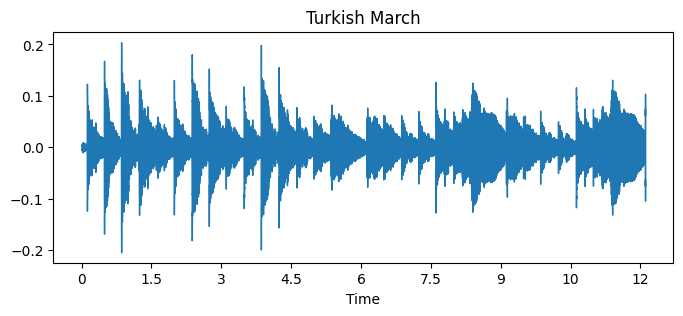

In [8]:
turkish_march_audio, tm_sr = librosa.load('turkish_march.wav', sr=44100)

print('Turkish March - Mozart')
display(Audio(turkish_march_audio, rate=tm_sr))

fig, ax = plt.subplots(figsize=(8, 3))
librosa.display.waveshow(np.array(turkish_march_audio), sr=tm_sr, ax=ax)
ax.set(title = 'Turkish March')

# Load Impulse Response for Reverb
impulse_response, _ = librosa.load("s1r2.wav", sr=None, mono=True)
impulse_response /= np.max(np.abs(impulse_response))



In [9]:
turkish_march_onsets = [0.105604, 0.478021, 0.826294, 1.226294, 1.591128, 1.991128, 2.342305, 2.717893, 3.079824, 3.472241, 3.831000, 4.231000, 4.589005, 4.957765, 5.333353, 6.105016, 
                        6.495016, 6.856193, 7.236193, 7.606193, 7.791749, 7.971749, 8.171749, 8.361749, 9.121749, 9.481749, 9.835550, 10.218321, 10.595544, 10.795544, 10.975544, 
                        11.155544, 11.361086]  

In [10]:
class Recording:
  def __init__(self, audio, sr, ref_onsets):
    self.audio = audio
    self.sr = sr
    self.ref_onsets = ref_onsets
    self.envelope = None
    self.onsets = None
    self.offsets = None
    self.rms = None
    self.notes = None
    self.envelope = None

In [11]:
turkish_march = Recording(turkish_march_audio, tm_sr, turkish_march_onsets)

### Choose Recording

❓ Initialize the variable `chosen_rec` with the name (string) of the recording in which you want to detect the onsets. The available names are the `recordings` dictionary keys.

In [12]:
recordings = {'turkish_march' : turkish_march}

# YOUR CODE HERE
chosen_rec = 'turkish_march'

print(f"Chosen recording: {chosen_rec}")

Chosen recording: turkish_march


### Choose Onset Detection Method

❓ Initialize the variable `chosen_method` with the name (string) of the method you want to use to detect the onsets. The available names are listed in the `methods` variable.

In [13]:
methods = ['nobt', 'wbt', 'btrms']

# YOUR CODE HERE
chosen_method = 'wbt'

print(f"Chosen method: {chosen_method}")

Chosen method: wbt


In [14]:
recording = recordings[chosen_rec]
D = np.abs(librosa.stft(recording.audio))
times = librosa.times_like(D)

### Onset and Offset Detector 

The function `librosa.onset.onset_strength()` computes a spectral flux onset strength envelope.

A peak-picking function can then be used to find the onsets of each note. The 
`librosa.onset.onset_detect()` function locates note onset events by picking peaks in the onset strength envelope. 

If the user specifies so, the function `librosa.onset.onset_backtrack` is used. It will backtrack from each peak to a preceding local minimum. Backtracking can be useful for finding segmentation points such that the onset occurs shortly after the beginning of the segment.

It can also backtrack the onsets using the RMS values, instead of the strength envelope.

As previously mentioned, the selected songs for this project have sequential notes, which allows us to assume that the conclusion of a particular note aligns with the onset of the next note. 


In [15]:
def get_onsets(recording, method, hop_length=512):

  # Compute the onset strength envelope
  onset_env = librosa.onset.onset_strength(y=recording.audio, sr=recording.sr)
  recording.envelope = onset_env
  
  # Onsets without backtracking
  onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=recording.sr, hop_length=hop_length, backtrack=False)
  if method == 'nobt':
    recording.onsets = onset_frames
    return

  # Onsets with backtracking
  onset_bt = librosa.onset.onset_backtrack(onset_frames, onset_env)
  if method == 'wbt':
    recording.onsets = onset_bt
    return

  # Onsets with RMS
  D = np.abs(librosa.stft(recording.audio))
  rms = librosa.feature.rms(S=D)
  onset_bt_rms = librosa.onset.onset_backtrack(onset_frames, rms[0])
  recording.envelope = rms[0]
  recording.onsets = onset_bt_rms

In [16]:
def get_offsets(recording):
  offsets = []
  for i in range(len(recording.onsets)-1):

    if i == len(recording.onsets) - 1:
      offsets.append(len(recording.audio)/recording.sr)
    else:
      offsets.append(librosa.frames_to_time(recording.onsets[i+1], sr=recording.sr))

  recording.offsets = offsets

In [17]:
def plot_onsets(recording):

  D = np.abs(librosa.stft(recording.audio))
  times = librosa.times_like(D)

  min = np.min(recording.audio) - np.min(recording.audio) * 0.2
  max = np.max(recording.audio) + np.max(recording.audio) * 0.2

  fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1, 1]})
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis='time', ax=ax[0])
  ax[0].set(title='Power spectrogram')
  ax[0].label_outer()

  # Plot the onset envelope
  ax[1].plot(times, recording.envelope, alpha=0.8, label='Mean (mel)')

  # Plot the onsets as vertical lines
  ax[1].vlines(times[recording.onsets], 0, recording.envelope.max(), color='r', alpha=0.9, linestyle='--', label='Onsets')

  librosa.display.waveshow(recording.audio, sr=recording.sr, ax=ax[2])
  ax[2].vlines(recording.ref_onsets, min, max, color='b', alpha=0.9, linestyle='--', label='Onsets')
  ax[2].vlines(times[recording.onsets], min, max, color='r', alpha=0.9, linestyle='--', label='Onsets')

  plt.tight_layout()
  plt.show()

### Detect and plot the onsets

The following piece of code detects the onsets of the chosen recording. The default value for the `hop_length` variable is 512, since it has proven to produce better results in the first part of the project.


In [18]:
onsets = get_onsets(recording, chosen_method, hop_length=512)
get_offsets(recording)
recording.onsets = librosa.frames_to_time(recording.onsets, sr=recording.sr)

### Metric calculation 

To assess the performance of our automatic onset detector, we used the ***f_measure*** function, from the *mir_eval* library, which determines the F1-score as well as the precision and recall.

This function then determines the true positive (TP), false positive (FP), and false negative (FN) using the human onsets and the automatic onsets. 

To classify each onset detection a tolerance window is used, if a automatically detected onset is within the tolerance window of the corresponding human detected onset than it is a true positive (TP). 

In [19]:
(f_measure, precision, recall) = mir_eval.onset.f_measure(np.array(recording.ref_onsets), recording.onsets, window = 0.05)

print(f"F-Measure: {f_measure:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

F-Measure: 1.0000
Precision: 1.0000
Recall: 1.0000


### Project 3 - Pitch and Intensity Detection
In the following part of the project we develop a pitch detection algorithm to determine the notes present in the audio files. Additionally, we use a frame-based RMS as an approach to determine the intensity of each note, which is another important component in order to accurately synthesize audio.

As mentioned previously, we use the autocorrelation and peak picking functions to determine the fundamental frequency of the note in a stable region of the signal. Additionally, we do some pre-processing of the signal to filter out components above the highest fundamental frequency of the piano, in order to obtain more a accurate note detection. For the intensity detection, we use the frame-based RMS varying the values of frame size and hop size to estimate accurately the values.



### Pitch Detection

#### Autocorrelation
Autocorrelation is a mathematical operation that measures the similarity of a signal with a time-delayed version of itself. It is used in pitch detection to estimate the fundamental frequency of a periodic signal. The autocorrelation function of a periodic signal has peaks at multiples of the fundamental frequency, which can be used to estimate the pitch of the signal.

$$
r_{x} (m) = \sum_{n=-\infty}^{+\infty} x(n) x(n+m)
$$
where the variable $m$ is called _lag_. 

By finding the maximum of the autocorrelation we get an estimate of the fundamental frequency. Note that the autocorrelation function always has a maximum at
$m$ = 0, so to not erroneously detecting the zero lag as maximum

In [20]:
def pitch(x, fs):
    """
    Compute the pitch of a signal x
    """
    x_normalized = librosa.util.normalize(x)
    acorr = librosa.autocorrelate(x_normalized)

    peaks = librosa.util.peak_pick(acorr, pre_max=16, post_max=16, pre_avg=3, post_avg=3, delta=0.45, wait=10)

    num_peaks = len(peaks)
    sum_freq = 0

    for i in range(num_peaks - 1):
      sum_freq += fs/(peaks[i+1] - peaks[i])
    
    f0 = (np.mean(sum_freq)/(num_peaks-1))

    return f0

In [21]:
def lowpass_filter(x, fs, fc):

    nyquist_rate = 0.5 * fs  # samples/s
    cutoff_normalized = fc / nyquist_rate

    filter_order = 100
    b = signal.firwin(filter_order, cutoff_normalized)
    x_filtered = signal.lfilter(b, 1, x)

    return x_filtered

In [22]:
def note_frequency(note):
  
    semitones = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    # YOUR CODE HERE
    base_freq = 440
      
    note_name = note[0].upper()
    if len(note) > 2:
      note_name += note[1]
    octave = int(note[-1])

    # Number of semitones from A4 to the given note
    semitones_from_a4 = (octave - 4) * 12 + semitones.index(note_name) - 9
    
    frequency = base_freq * 2**(semitones_from_a4/12)

    return frequency

In [23]:
def note_audio(recording, onset_idx):

  note_start = recording.onsets[onset_idx]

  if onset_idx == len(recording.onsets) - 1:
    note_end = len(recording.audio)/recording.sr
  else:
    note_end = recording.onsets[onset_idx + 1]

  n_seg = np.arange(note_start*recording.sr, note_end*recording.sr, dtype=int)
  note = recording.audio[n_seg]

  return note, note_start

In [24]:
def stable_region(recording, note_audio, note_start, onset_idx):

  if onset_idx != len(recording.onsets) - 1:
    window_size_sec = (recording.onsets[onset_idx+1] - recording.onsets[onset_idx]) * 0.09
  else:
    window_size_sec = ((len(recording.audio)/recording.sr - recording.onsets[onset_idx])) * 0.09

  window_size = int(recording.sr * window_size_sec)

  amplitude_envelope = librosa.amplitude_to_db(note_audio)

  # Compute variance for each window
  variances = []
  for i in range(0, len(amplitude_envelope) - window_size, window_size):
      window = amplitude_envelope[i:i+window_size]
      variances.append(window.var())

  # Find window with lowest variance
  stable_region_start = variances.index(min(variances)) * window_size
  stable_region_end = stable_region_start + window_size

  n_seg = np.arange(note_start*recording.sr+stable_region_start, note_start*recording.sr+stable_region_end, dtype=int)

  stable_audio = recording.audio[n_seg]
  
  return stable_audio

In [25]:
def get_pitches(recording):

  n_onsets = len(recording.onsets)
  pitches = []

  for i in range(n_onsets):
    note, note_start = note_audio(recording, i)
    stable_audio = stable_region(recording, note, note_start, i)
    filtered_audio = lowpass_filter(stable_audio, recording.sr, 4200)
    note_pitch = pitch(filtered_audio, recording.sr)
    pitches.append(note_pitch)

  return pitches

recording.notes = get_pitches(recording)

### Intensity Detection

#### Frame Based RMS

The frame-based RMS algorithm is a method for calculating the intensity or loudness of musical notes over a series of frames, which are small sections of the audio signal. The algorithm divides the audio signal into frames and calculates the RMS amplitude of each frame. 

$$
RMS = \sqrt{\frac{1}{N} ∑_{i} x_i^2}
$$


In [26]:
def rms(x, frame_size, hop_size):
    """Compute the RMS of a signal in frames.
    
    Parameters
    ----------
    x : np.ndarray
        Input signal.
    frame_size : int
        Frame size in samples. If 0, the whole signal is used.
    hop_size : int
        Hop size in samples. If 0, the frame size is divided by 4.
    
    Returns
    -------
    rms : np.ndarraymusical no
        RMS of the signal in frames.
    """
    if frame_size == 0:
        frame_size = len(x)
        hop_size = frame_size
    if hop_size == 0:
        hop_size = frame_size/4
        
    num_frames = 1 + int(np.floor((len(x) - frame_size) / hop_size))
    fbrms = np.zeros(num_frames)

    # RMS for each frame
    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        fbrms[i] = np.sqrt(np.mean(x[start:end] ** 2))

    return fbrms

In [27]:
def get_intensity(recording, n_seg, frame_size, hop_size):
    """
    Get intensity of note 
    """
    frms = rms(recording.audio[n_seg], frame_size , hop_size )

    intensity = np.mean(frms)
    
    return intensity

In [28]:
def dbfs(amplitude):
    """
    Convert amplitude to decibels relative to full scale.
    """
    v0 = 1
    db = 20 * np.log10(amplitude/v0)
    return db

### Choose frame size and hop size
❓ Modify the values of frame size and hop size to your liking. While the intensity values of individual notes are expected to vary, it is anticipated that these variations will be imperceptible when listening to the entire musical piece as a whole.

In [29]:
notes_intensity = []
notes_intensity_db = []
frame_size = 1102
hop_size = 551

for i in range(len(recording.onsets)):

  note_start = recording.onsets[i]

  if i == len(recording.onsets) - 1:
    note_end = len(recording.audio)/recording.sr 
  else: 
    note_end = recording.onsets[i+1] 
    
  n_seg = np.arange(note_start*recording.sr, note_end*recording.sr, dtype=int)

  intensity = get_intensity(recording, n_seg, frame_size, hop_size)
  notes_intensity.append(intensity)
  intensity_db = dbfs(intensity)
  notes_intensity_db.append(intensity_db)

recording.rms = notes_intensity

### Proj 2 Polyphonic Synthesizer

In this part of the project, we implemented a synthesizer that has several key components, including a wavetable generator, wavetable synthesis, an ADSR envelope.
The wavetable generator is responsible for generating the basic sound waves used to create the notes, while the wavetable synthesis component takes the generated waveform samples and uses them to create a waveform for each note. The ADSR envelope has four key parameters: Attack, Decay, Sustain, and Release. These parameters control how the volume of the note changes over time.

A crucial detail of this synthesizer is that it is polyphonic, meaning that allows for multiple notes to be played at the same time. We achieve that by adding the envelope at the appropriate time instead of concatenating them.

As previously mentioned, we incorporated several additional enhancements to increase the realism of the synthesized audio. To achieve this, we studied the piano's structure, with a particular focus on the number of strings that vibrate when a key is pressed and the distinguishing characteristics of a piano's sound.

### ADSR Envelope

The envelope of a waveform is one of the sound characteristics that influence the timbre of a sound.  It determines the shape of a waveform and how it changes over time. 

By manipulating the envelope, it is possible to emulate the dynamic behaviour of acoustic instruments, or to create entirely new dynamics. Therefore, in order to make our synthesized audio sound more realistic we studied the behaviour of an ADSR envelope for a piano, which has a fast attack and the sustain\decay gradually decreases in volume over time until the note is released.

In the figure below we present the ADSR envelope for a piano.

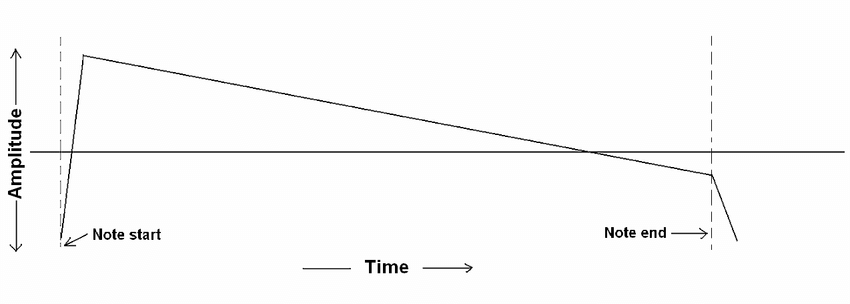

In [30]:
def adsr_envelope(x, height=1.0):

    shape = np.exp(0.3 * np.linspace(np.log(1), np.log(0.0001), len(x)))

    return x * shape * height

### Determing Number of Harmonics

An important characteristic of piano sound is dependent on the nonlinear behavior of piano hammers. In a standard piano, depending on the region, the string spectra can contain a different number of harmonics. For the bass region, situated between C0 and F2, there is an average of 55 harmonics that extend out to about 5000 Hz. For the middle region, ranging from F#2 to C#4, the string spectra have 25 harmonics that extend out to about 7000 Hz. Finally, the treble region is characterized by having fewer harmonics, around 2.

The function `number_harmonics` determines the number of harmonics of each note based on the frequency.

In [32]:
def number_harmonics(frequency):

  n_harmonics = 0

  if frequency <= 90:
    # C0 --> F2
    n_harmonics = 55
  elif frequency > 90 and frequency <= 280:
    # F#2 --> C#4
    n_harmonics = 25
  elif frequency > 280 and frequency <= 1250:
    # D4 --> D#6
    n_harmonics = 8
  else:
    # E6 --> C8
    n_harmonics = 2

  return n_harmonics

### Generating a Waveform

The function `wave` generates waveform by combining sine waves at different harmonics of a given frequency, as explained in the previous section, with optional detuning, and returns the resulting waveform as a normalized numpy array.

In [33]:
def wave(frequency, duration, fs, detunes=[0]):

  t = np.linspace(0, duration, int(fs*duration), False)

  n_harmonics = number_harmonics(frequency)

  harmonics = [i for i in range(2, n_harmonics + 1)]
  freqs = [(frequency + detune) * h for detune in detunes for h in harmonics]

  first_harmonic = np.sin(2*np.pi*frequency*t)
  waves = [(0.6 * np.sin(2*np.pi*f*t)) for f, h in zip(freqs, harmonics)]

  waves = first_harmonic + waves            

  waveform = sum(waves)

  waveform /= np.max(np.abs(waveform))


  return waveform

### Determining Number of Strings

The unique sound of a piano is determined by its strings, as the tenor and treble notes are produced by striking three strings simultaneously, while bass notes are played on only one string, with the number of strings gradually decreasing in between. 

However, when struck by the piano hammer, the strings do not oscillate uniformly, but rather at specific intervals from each other. This variation is introduced by the `detunes` variable, where the strings are played with a 0.5 Hz interval.

The function `number_strings` determines the number of strings needed to be played simultaneously using the frequency of the note.

In [34]:
def number_strings(frequency):

  n_strings = 0
  detunes = {1: [0], 2: [-0.5, 0.5], 3: [-0.5, 0, 0.5]}

  if frequency <= 56.6:
    # A0 --> A1
    n_strings = 1
  elif frequency > 56.6 and frequency <= 151.2:
    # A#1 --> D3
    n_strings = 2
  else:
    # D#3 --> C8
    n_strings = 3

  return detunes[n_strings]

### Note Synthesis

The `synt_note` function creates a synthetic piano note that attemps to sound similiar to an actual piano note. It starts by determining the number of strings to be played for a given frequency, as explained in the previous section and generates the waveform using the `wave` function. Next, it adds the generated waveform with the string sound and normalizes the resulting signal. In order to achieve a more realistic piano note, we decided to add a hammer sound and pad this with zeros to have the size size as note.

In [35]:
def synt_note(frequency, duration, fs, hammer):

  detunes = number_strings(frequency)

  note = wave(frequency, duration, fs=fs, detunes=detunes)
  note /= np.max(np.abs(note))
  note = adsr_envelope(note)
  
  note /= np.max(np.abs(note))

  hammer_noise = hammer
  num_zeros = len(note) - len(hammer_noise)

  if num_zeros > 0:
    hammer_noise = np.pad(hammer_noise, (0, num_zeros), mode='constant')
  else:
    hammer_noise = np.resize(hammer_noise, len(note))

  note = note + 0.5 * hammer_noise
  note /= np.max(np.abs(note))

  return note

### Synthesis of a Musical Composition

The function `synthesize_composition` synthesizes a sound signal based on a symbolic representation of a musical composition. We adapted the original code which is a monophonic synthesizer to implement polyphony.

The difference between a monophonic synthesizer and a polyphonic synthesizer is the number of notes that can be played at the same time, with the monophonic being restricted to one note at a time, and the polyphonic being able to play multiple notes simultaneously.

To play multiple notes at the same time, we determine the start and end indices of each note using the onset time and the length of the envelope. The scaled waveform is then added to the composite waveform, at the specific time dictated by the indices we calculated previously.

In [36]:
def synthesize_composition(composition, fs, hammer_noise):
    """
    Synthesize a sound signal based on a symbolic representation of a
    musical composition
    """
    # Determine the length of the composition (max offset)
    total_duration = max(list(zip(*composition))[3])

    # Create an empty array to hold the composite waveform
    out = np.zeros(int(total_duration*fs))

    # Loop over each note in the composition
    for freq, amplitude, onset, offset in composition:
      
      #freq = note_frequency(note)
      env = amplitude * synt_note(freq, offset-onset, fs, hammer_noise)

      # Add the scaled waveform to the composite waveform at the appropriate time
      start_index = int(onset*fs)
      end_index = start_index + len(env)
      out[start_index:end_index] += env

    return out

### Hammer Noise

Another important characteristic of the piano is the distinctive sound of the hammer hitting the strings. When a key is pressed, the hammer inside the piano is lifted and released to strike the corresponding string, generating a sound that is rich in harmonics and has a unique tonal quality. To make our synthesized sound more realistic, we load the hammer noise and use signal processing techniques to modify and blend it with the synthesized piano samples.

In [37]:
hammer_noise = np.load('hammer_noise.npy')

### Create Composition

In order to test the impact of the add-ons aimed at making the piano sounds more realistic, reference onset times were used instead of an onset detector. Although the onset detector had good performance as we will see in the assessment section, it still produced errors that could affect the pitch detection algorithm, possibly leading to a failure to detect any frequency during the duration of the note. 

Using the results obtained from the pitch detector, intensity detector, and onset detector, we formulate a musical arrangement in the format of:

<center> <p style="text-align: center;">(frequency, amplitude, onset, offset)</p> </center>

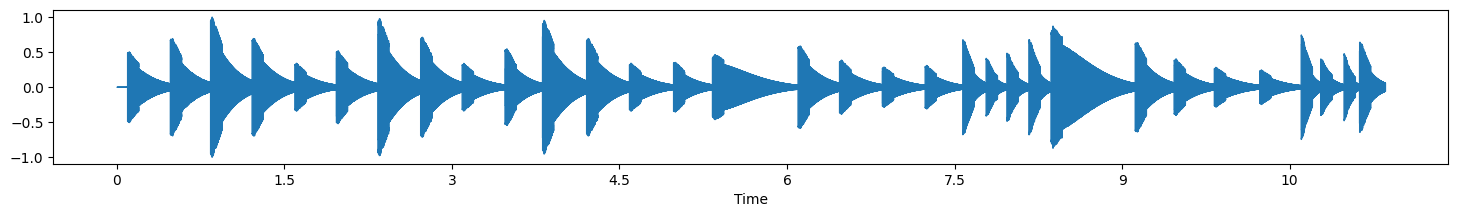

In [38]:
composition = list(zip(recording.notes, recording.rms, recording.onsets, recording.offsets))

synth_comp = synthesize_composition(composition, recording.sr, hammer_noise)
synth_comp /= np.max(np.abs(synth_comp))

display(Audio(synth_comp, rate=recording.sr))
fig, ax = plt.subplots(figsize=(18, 2))
librosa.display.waveshow(np.array(synth_comp), sr=recording.sr, ax=ax)

### Adding Reverb

In an effort to make the synthesized audio file sound more realistic, we also explored the reverb effect which is essentially a convolution between the synthesized signal and a impulse response. In this case, we used an impulse response recorded in a concert hall. 

To apply the reverb effect to an input audio signal x[n], the impulse response h[n] is convolved with the input signal x[n] using the convolution formula:

$$
  y[n] = (x * h)[n] = \sum_{m=- ∞}^{+∞} x[m] * h[n-m]
$$

In [39]:
# Convolve the audio signal with the impulse response
reverb_signal = signal.convolve(synth_comp, impulse_response, mode="full")[:len(synth_comp)]

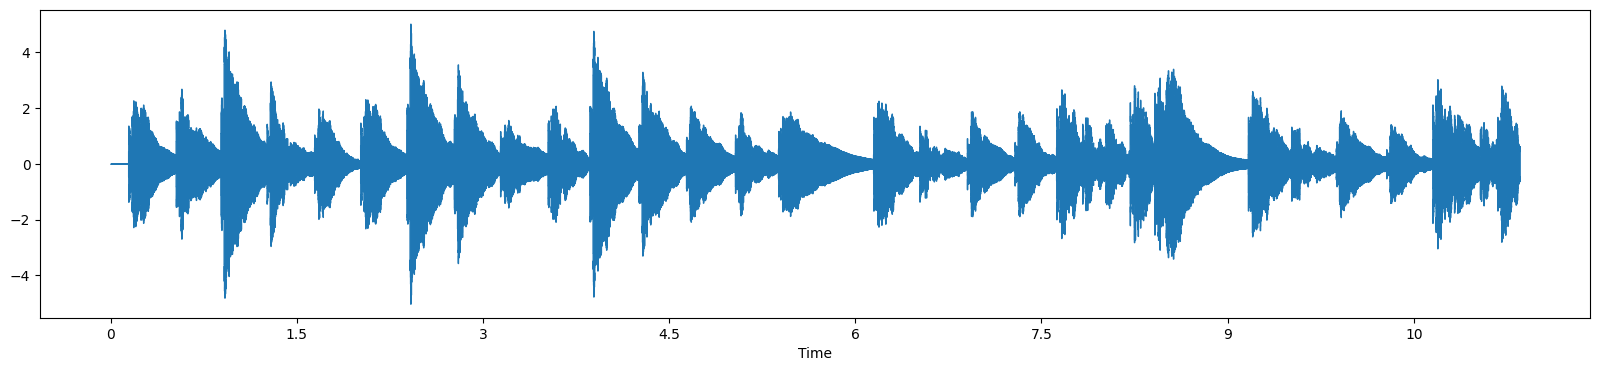

In [40]:
display(Audio(reverb_signal, rate=44100))
fig, ax = plt.subplots(figsize=(20, 4))
librosa.display.waveshow(np.array(reverb_signal), sr=44100, ax=ax)

### Comparing With a MIDI File

To assess the performance of our synthesizer and determine if the quality of the synthesized audio improves, we decided to test it using a MIDI file, which is a more common file format.

We used two MIDI files that was available in the description of both Youtube videos where the compositions are played on a piano.

<br>

Youtube Link for Eine Kleine Nachtmusik: https://www.youtube.com/watch?v=etr_z9Z51QE

MIDI file: https://www.dropbox.com/s/pc3ueh2q553isfk/W.A.%20Mozart%20-%20Eine%20kleine%20nachtmusik.mid?dl=0

Youtube Link for 5th Symphony: https://www.youtube.com/watch?v=Nr2U7QGEkMQ

MIDI file: https://www.dropbox.com/s/9jzxesa3cce2t5j/Ludwig%20van%20Beethoven-%20Symphony%20No.%205.mid?dl=0


In [41]:
def mid2composition(filename, duration):

  # Load MIDI file
  midi_data = pretty_midi.PrettyMIDI(filename)

  # Initialize a list to store note information tuples
  composition = []
  notes_list = []

  # Iterate over all notes in all instruments
  for instrument in midi_data.instruments:
    for note in instrument.notes:
      if note.end <= duration:
        # Get the name of the note (e.g. "C#4" for MIDI note number 61)
        note_name = pretty_midi.note_number_to_name(note.pitch)
        if note_name not in notes_list:
          notes_list.append(note_name)
        note_freq = note_frequency(note_name)

        # Add the note information tuple to the note_info list
        composition.append((note_freq, note.velocity/127, note.start, note.end+0.3))
      else:
        break

  return composition, notes_list

### Choose MIDI File

❓ Initialize the variable `chosen_mid` with the name (string) of the MIDI file you want to use to synthesize. The available names are listed in the `midi` variable.

In [42]:
midi = {'mozart' : 'mozart.mid', 'beethoven' : '5_symphony.mid'}
original = {'mozart' : 'mozart.wav', 'beethoven' : '5th_symphony.wav'}

# YOUR CODE HERE
chosen_mid = 'mozart'

print(f"Chosen recording: {chosen_mid}")

midi_file = midi[chosen_mid]
original_wav = original[chosen_mid]

Chosen recording: mozart


In [43]:
fs = 44100
composition, notes_list = mid2composition(midi_file, duration=20)
synth_composition = synthesize_composition(composition, fs, hammer_noise)
synth_composition /= np.max(np.abs(synth_composition))

Original Audio File


Synthesized Composition


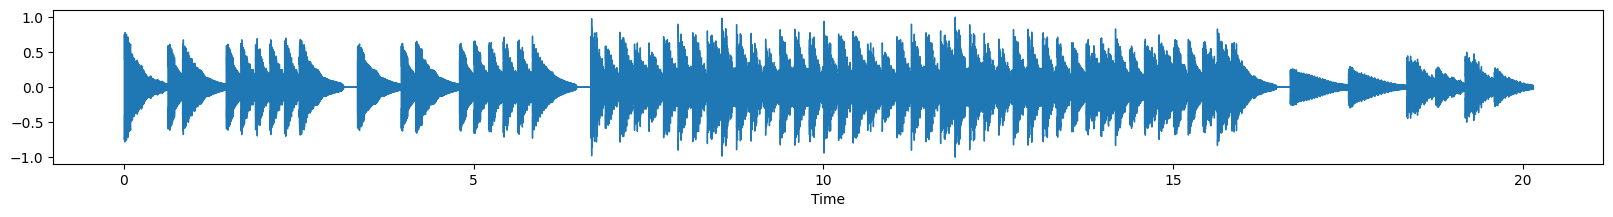

In [44]:
original_audio, original_fs = librosa.load(original_wav, sr = 44100)
print('Original Audio File')
display(Audio(original_audio, rate=original_fs))

print('Synthesized Composition')
display(Audio(synth_composition, rate=fs))
fig, ax = plt.subplots(figsize=(20, 2))
librosa.display.waveshow(np.array(synth_composition), sr=fs, ax=ax)

### Assessment


|               | F1 Measure | Recall | Precision |
|---------------|------------|--------|-----------|
| Turkish March |   1.0000   | 1.0000 |   1.0000  |


In the table above, we presented the results of our onset detector, which showed an excelent performance for the chosen file. However, to ensure the accuracy of the pitch and intensity detection for each note, we still opted to use our reference onsets. This is because even with the good performance of the onset detector, there is still some error present, which can result in the pitch detector algorithm failing to detect a note during its supposed interval, making it impossible to synthesize the signal.

In the table below, we present the results obtain for the pitch detection algoritm for three different recordings, that we tested previously and chose the only the Turkish March in order to test the whole architecture of the synthesizer.


<br>

|      | Turkish March | Nachtmusik | Minuet |
|:-----------------:|:-----------:|:------------:|:-----------:|
|      **Accuracy [%]**     |    87.88   |    70.00    |    54.54   |

<br>

The algorithm performed better on the "Turkish March" composition compared to "Eine Kleine Nachtmusik" and "Minuet" by Bach. This is due to the fact that the section used for "Turkish March" is always played in the same octave, while the other compositions have notes played in different octaves which affect the accuracy of the pitch detection. "Minuet" had the worst results possibly due to being played in lower octaves than the other compositions. And is the reason why we decided to only test our developed synthesizer with the "Turkish March" audio file.

The pitch detector was tuned for the first two compositions, which have notes with higher frequencies and, therefore faster variations in the time domain. So, the `librosa.util.peak_pick` function was tuned to be sensible to this more energic variations. While this makes the detector great to detect the higher notes,  it makes it not so good at detecting lower notes. 

| Frame Size | Hop Size |   Recording   |  MAE  |
|:----------:|:--------:|:-------------:|:------:|
|     220    |    55    | Turkish March | 0.6809 |
|     220    |    110   | Turkish March | 0.6644 |
|    1102    |    275   | Turkish March | 0.5792 |
|    1102    |    551   | Turkish March | 0.5160 |
|    2048    |   1024   | Turkish March | 0.4931 |
|    2205    |   1102   | Turkish March | 0.4706 |

<br>

In the table above, we observe the results for the intensity detector for different `frame size` and `hop size` values. As is expected, we mean absolute error is smaller for greater values of frame size, since it provides more information about the intensity of the note over a longer time interval.

After comparing the synthesized audio file obtained from the MIDI file with the synthesized audio file obtained through the process of determining each note and its intensity, we can conclude that the MIDI file produces a much cleaner audio output, which is in line with our expectations.

As observed in the results above, the accuracy of both the pitch and intensity detectors is not near 100%. Therefore, it is expected that the synthesized audio file obtained from the MIDI file, which does not require these detectors, produces a much cleaner audio output.

A possible justification is that pitch detection algorithms are prone to false detection problems, often resulting in "octave errors," where the algorithm detects a pitch that is either one or more octaves above or below the actual pitch. This can occur if there is noise around a sub-harmonic of the pitch frequency or if there are strong overtones and harmonics. 

There could be several reasons why the frame-based RMS detector produces errors. Firstly, it is sensitive to noise and can provide inaccurate results when the input signal contains noise, which could occur due to the extraction of audio files from YouTube. The choice of frame size and overlap can have a significant impact on the accuracy of the RMS intensity measurement. If the frame size is too small, the RMS intensity may not be representative of the overall loudness of the note.

Upon comparing the original sound with the synthesized version using MIDI files, it can be concluded that they are similar sound-wise, however, there is still room for improvement as it is still possible to clearly distinguish which one is synthesized.

### Code tests

❓Use the next cells to include tests of your code. Call the functions that you have developed with known inputs and compare its return values with the expected results.

In [45]:
assert np.isclose(note_frequency('A4'), 440)
assert np.isclose(note_frequency('A5'), 880)

In [46]:
assert np.isclose(np.sum(rms(np.ones(1000), 100, 100)), 10.)

In [47]:
x, fs = librosa.load(librosa.ex('trumpet'), duration = 0.4)
ref_onset = [0, 0.194047]
trumpet = Recording(x, fs, ref_onset)
trumpet.onsets = ref_onset

pitches = get_pitches(trumpet)
print(librosa.hz_to_note(pitches))

assert np.isclose(pitches[0], 622.25, atol = 3)
assert np.isclose(pitches[1], 587.33, atol = 3)

['D♯5' 'D5']


In [48]:
detunes = number_strings(100)

assert np.isclose(detunes[0], -0.5)
assert np.isclose(detunes[1], 0.5)

In [49]:
assert np.isclose(number_harmonics(1000), 8)

### Demonstration Video

In the video below, we present an overview of our project of a digital synthesizer for piano recordings. 

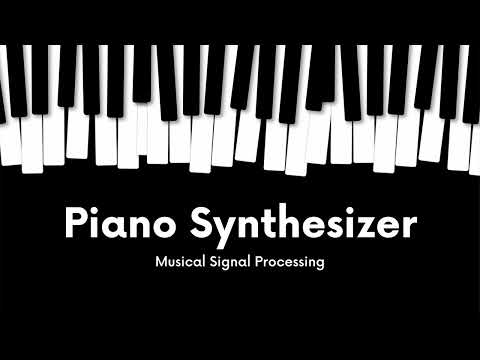

In [50]:
YouTubeVideo('kdGRcO_2nXM')